In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

### Create ImageNet validation dataset

In [2]:
# using the validation transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## Randomly subsample features too

data_path='/datasets01/imagenet_full_size/061417/'
dataset = torchvision.datasets.ImageFolder(data_path + 'val', transform=transform)

In [3]:
data_loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=128,
                                        shuffle=False,
                                        pin_memory=False)

log_every = 10
do_log = True

## Compare finetuning dynamics

In [4]:
from ast import literal_eval

In [19]:
results = {'MAE': [], 'MoCoV3': [], 'DINO': []}

for key in results:
    folder_name = "../checkpoints/" + key.lower() + "-norm/"
    log_file = folder_name + "ft_log.txt"

    log_list = []
    print(log_file)
    if os.path.isfile(log_file): 
        with open(log_file, "r") as log:
            for line in log:
                log_dict = literal_eval(line)
                log_list.append(log_dict)
               
    df = pd.DataFrame(log_list)
    df = df.set_index('epoch')
    results[key] = df

../checkpoints/mae-norm/ft_log.txt
../checkpoints/mocov3-norm/ft_log.txt
../checkpoints/dino-norm/ft_log.txt


In [20]:
for key in results:
    results[key]['change_lr'] = results[key]['train_norm_params_change'] / results[key]['train_lr']
    results[key]['change_lr_cumsum'] = results[key]['change_lr'].cumsum()
    results[key]['train_norm_params_change_cumsum'] = results[key]['train_norm_params_change'].cumsum()

    results[key].rename(columns={"change_lr": "L2-norm ΔParameters (LR scaled)", "train_norm_params_change": "L2-norm ΔParameters", "train_norm_params_after_update": 
                                "L2-norm Parameters", "change_lr_cumsum": "L2-norm ΔParameters (LR scaled, Cumulative Sum)", "train_norm_params_change_cumsum": 
                                "L2-norm ΔParameters (Cumulative Sum)"}, inplace=True)

    results[key]['L2-norm ΔParameters / L2-norm Parameters'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters']
    results[key]['L2-norm ΔParameters / L2-norm Parameters (converged)'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters'].iloc[-1]
    results[key]['L2-norm ΔParameters / L2-norm Parameters (initial)'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters'].iloc[0]
    

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [7]:
def dynamics_plot(fig_dir, df1, df2, name1, name2, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 9), dpi=300, sharex=True)

    sns.lineplot(x='epoch', y=col, data = df1, ax = ax1)
    sns.lineplot(x='epoch', y=col, data = df2, ax = ax1)

    axins1 = inset_axes(ax1,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins1)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins1)
    axins1.set_xlim([0,8])
    axins1.set_xlabel("")
    axins1.set_ylabel("")

    sns.lineplot(x='epoch', y='test_acc1', data = df1, linestyle='--', ax = ax2)
    sns.lineplot(x='epoch', y='test_acc1', data = df2, linestyle='--', ax = ax2)

    axins2 = inset_axes(ax2, "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y='test_acc1', data = df1, linestyle='--', ax = axins2)
    sns.lineplot(x='epoch', y='test_acc1', data = df2, linestyle='--', ax = axins2)
    axins2.set_xlim([0,8])
    axins2.set_xlabel("")
    axins2.set_ylabel("")

    sns.lineplot(x='epoch', y='test_acc5', data = df1, linestyle='dashdot', ax = ax3)
    sns.lineplot(x='epoch', y='test_acc5', data = df2, linestyle='dashdot', ax = ax3)

    axins3 = inset_axes(ax3, "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y='test_acc5', data = df1, linestyle='--', ax = axins3)
    sns.lineplot(x='epoch', y='test_acc5', data = df2, linestyle='--', ax = axins3)
    axins3.set_xlim([0,8])
    axins3.set_xlabel("")
    axins3.set_ylabel("")

    ax3.set_xlabel("Fine-tuning Epochs")
    ax1.set_ylabel(col)
    ax2.set_ylabel('Test accuracy top-1')
    ax3.set_ylabel('Test accuracy top-5')

    ax2.legend(title='Pre-training algorithm', loc='lower center', labels=[name1, name2])
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-'+name2+'.png')

    return fig


In [14]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    sns.lineplot(x='epoch', y=col, data = df1, ax = ax)
    sns.lineplot(x='epoch', y=col, data = df2, ax = ax)
    sns.lineplot(x='epoch', y=col, data = df3, ax = ax)

    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''
    
    ax.set_xlabel("Fine-tuning Epochs")
    ax.set_ylabel(col)
    
    ax.legend(title='Pre-training algorithm', loc='lower center', labels=[name1, name2, name3])
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'.png')

    return fig

In [9]:
import itertools

In [ ]:
fig_dir = '../figures/dynamics/'

prod = itertools.combinations(results.keys(), 2)

for name1, name2 in prod:

    for col in ["L2-norm ΔParameters (LR scaled)", "L2-norm ΔParameters", "L2-norm Parameters", 
                "L2-norm ΔParameters (LR scaled, Cumulative Sum)", "L2-norm ΔParameters (Cumulative Sum)"]:
        full_fig_dir = fig_dir + col + '/'
        fig = dynamics_plot(full_fig_dir, results[name1], results[name2], name1, name2, col=col)

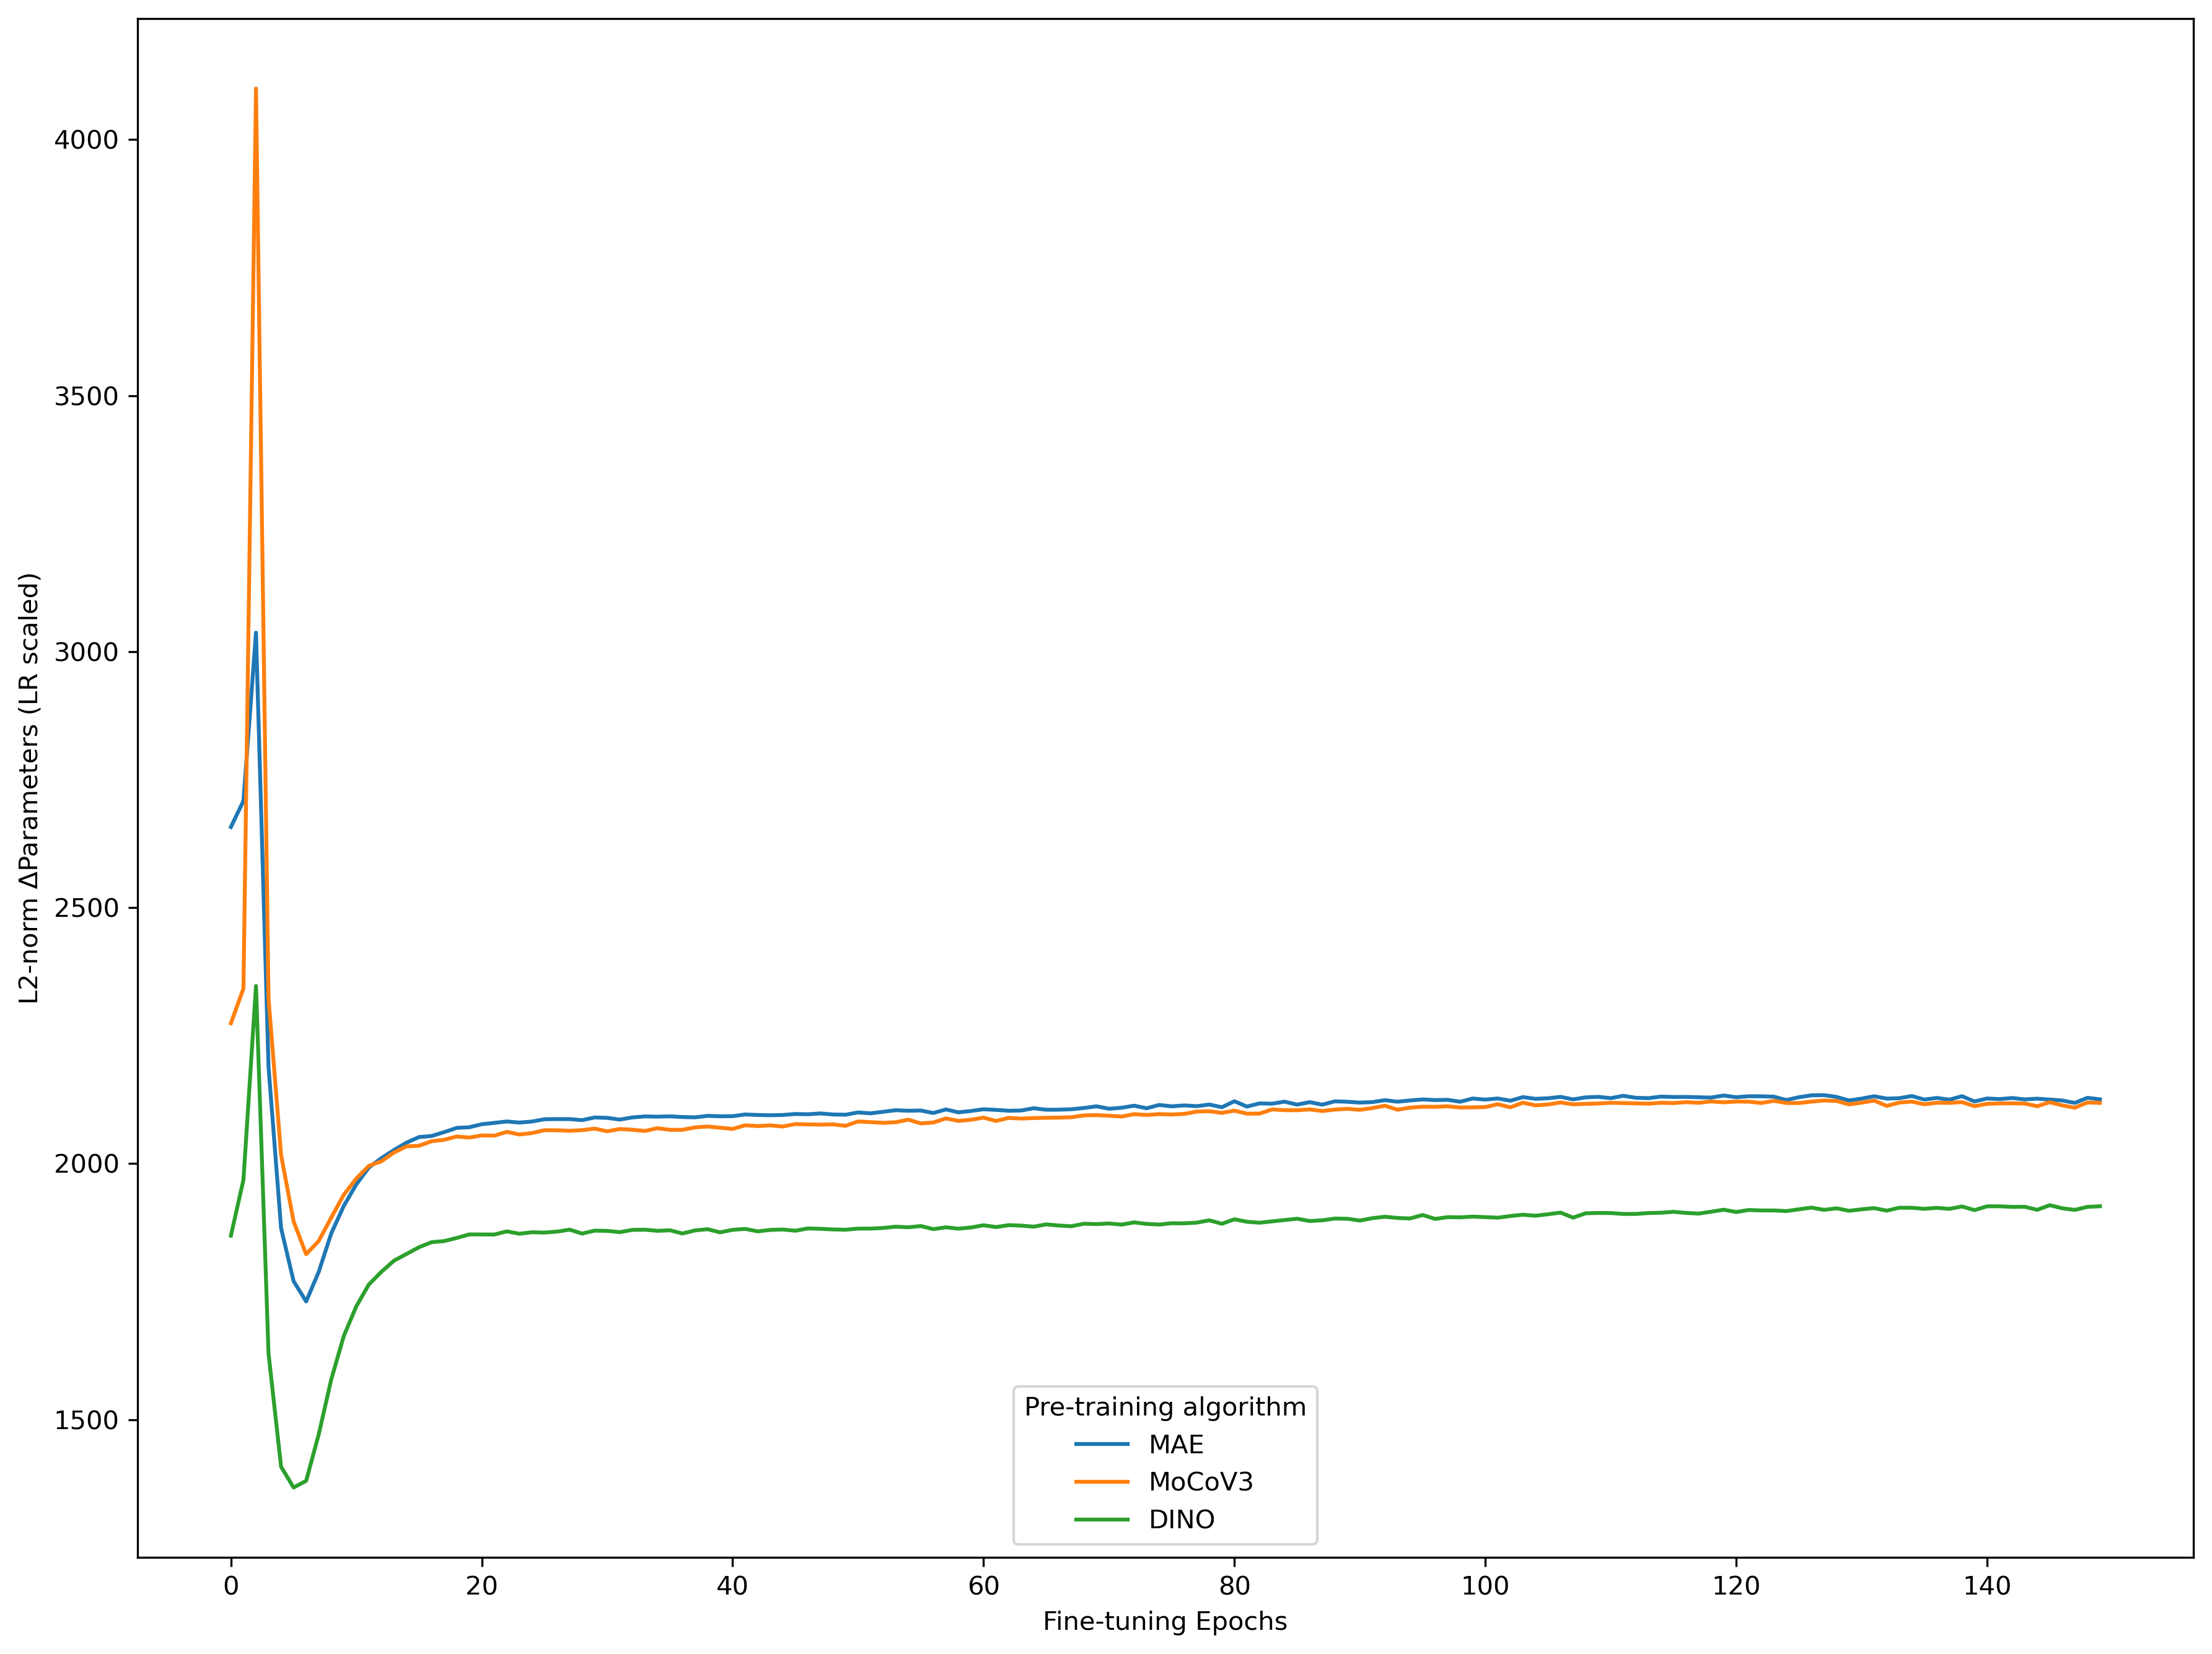

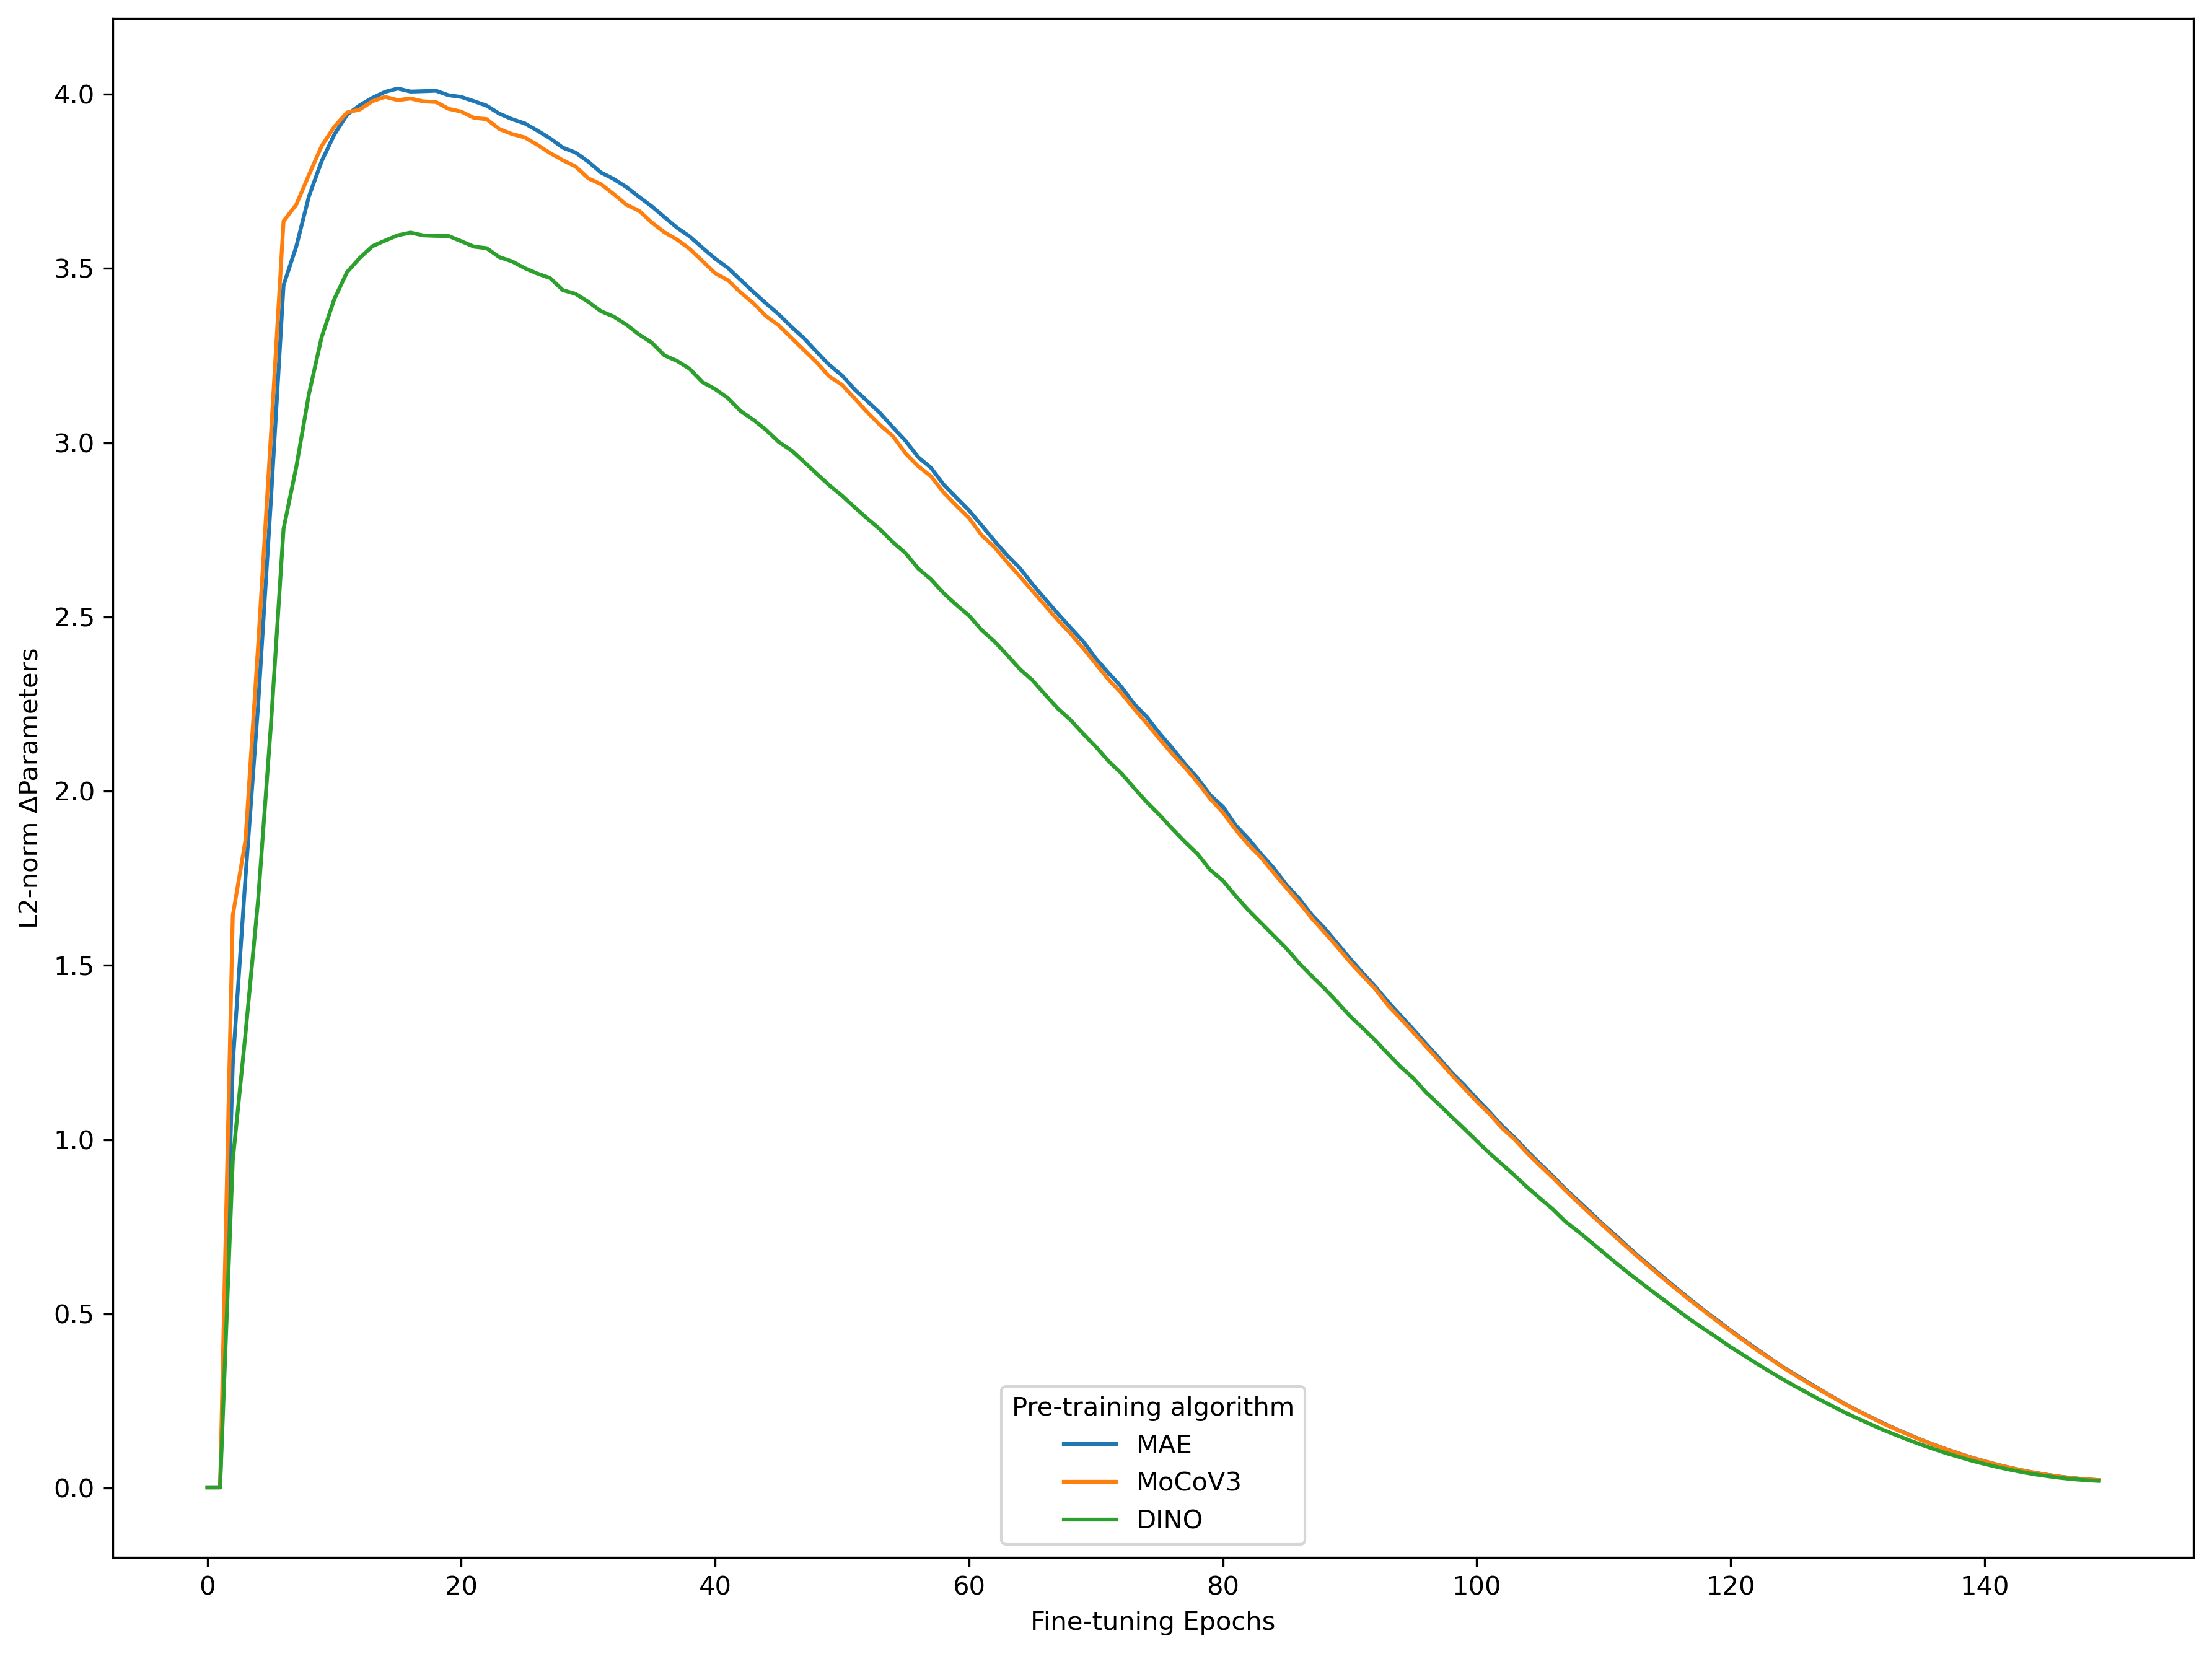

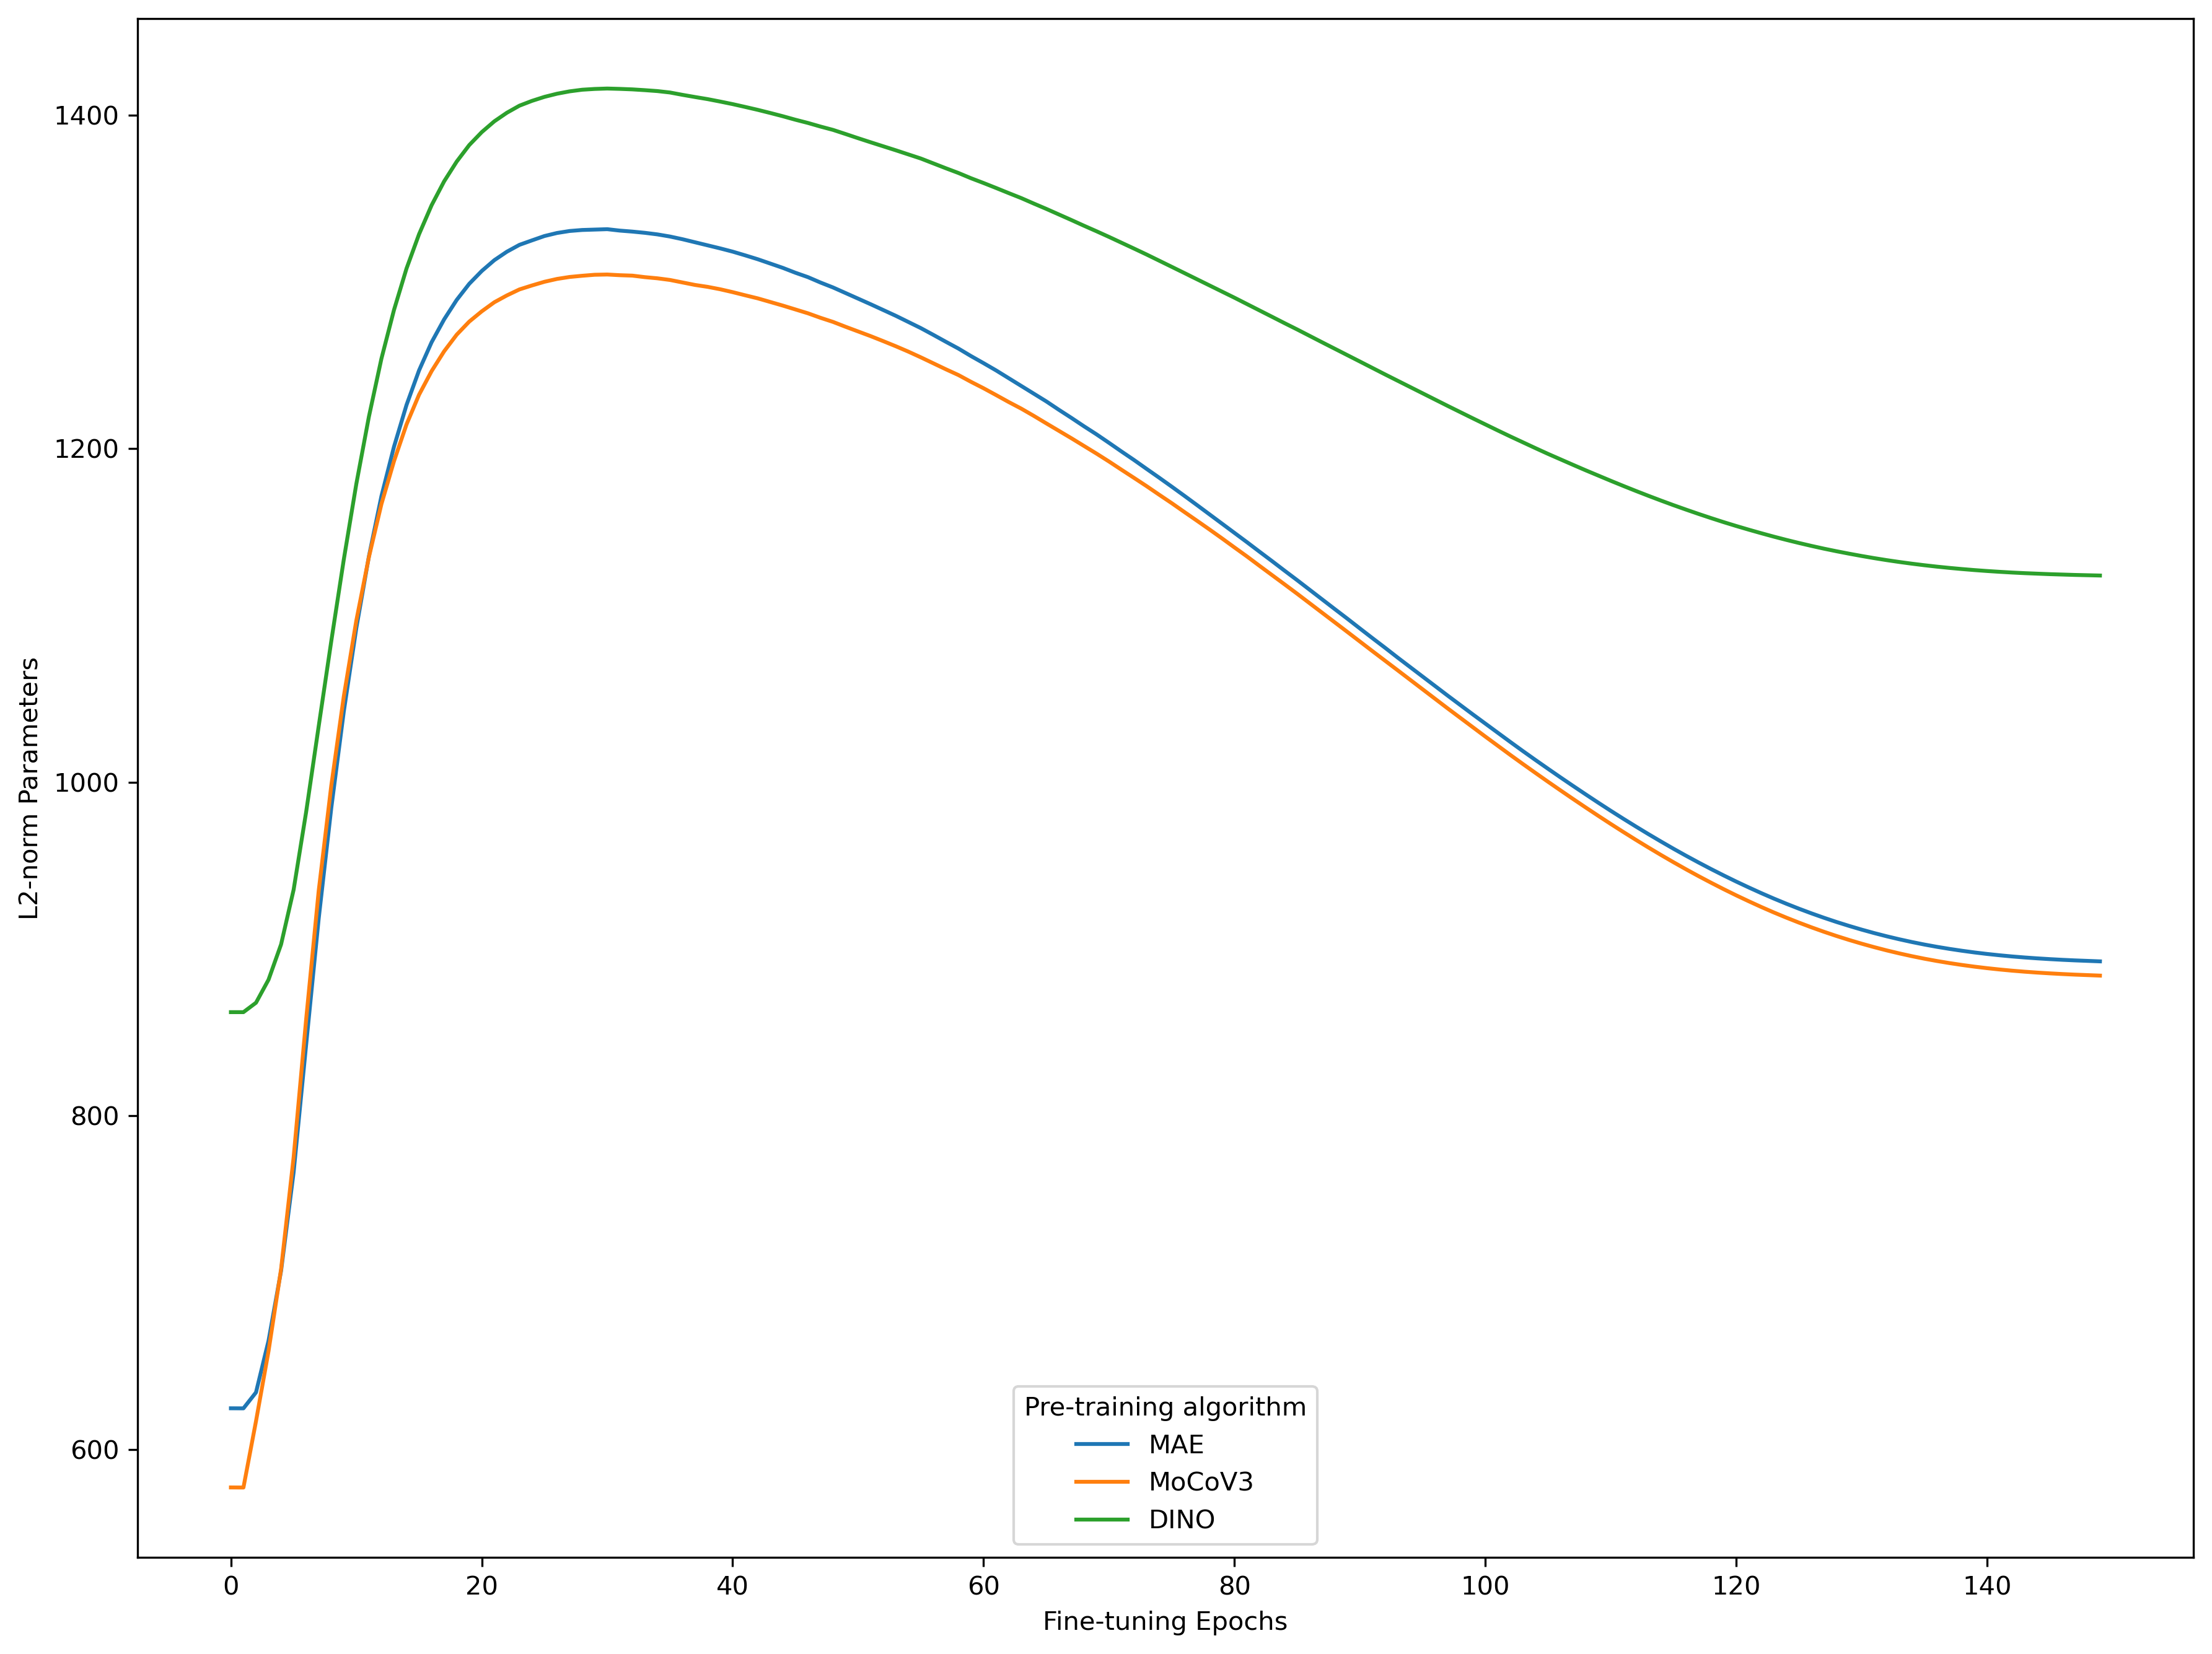

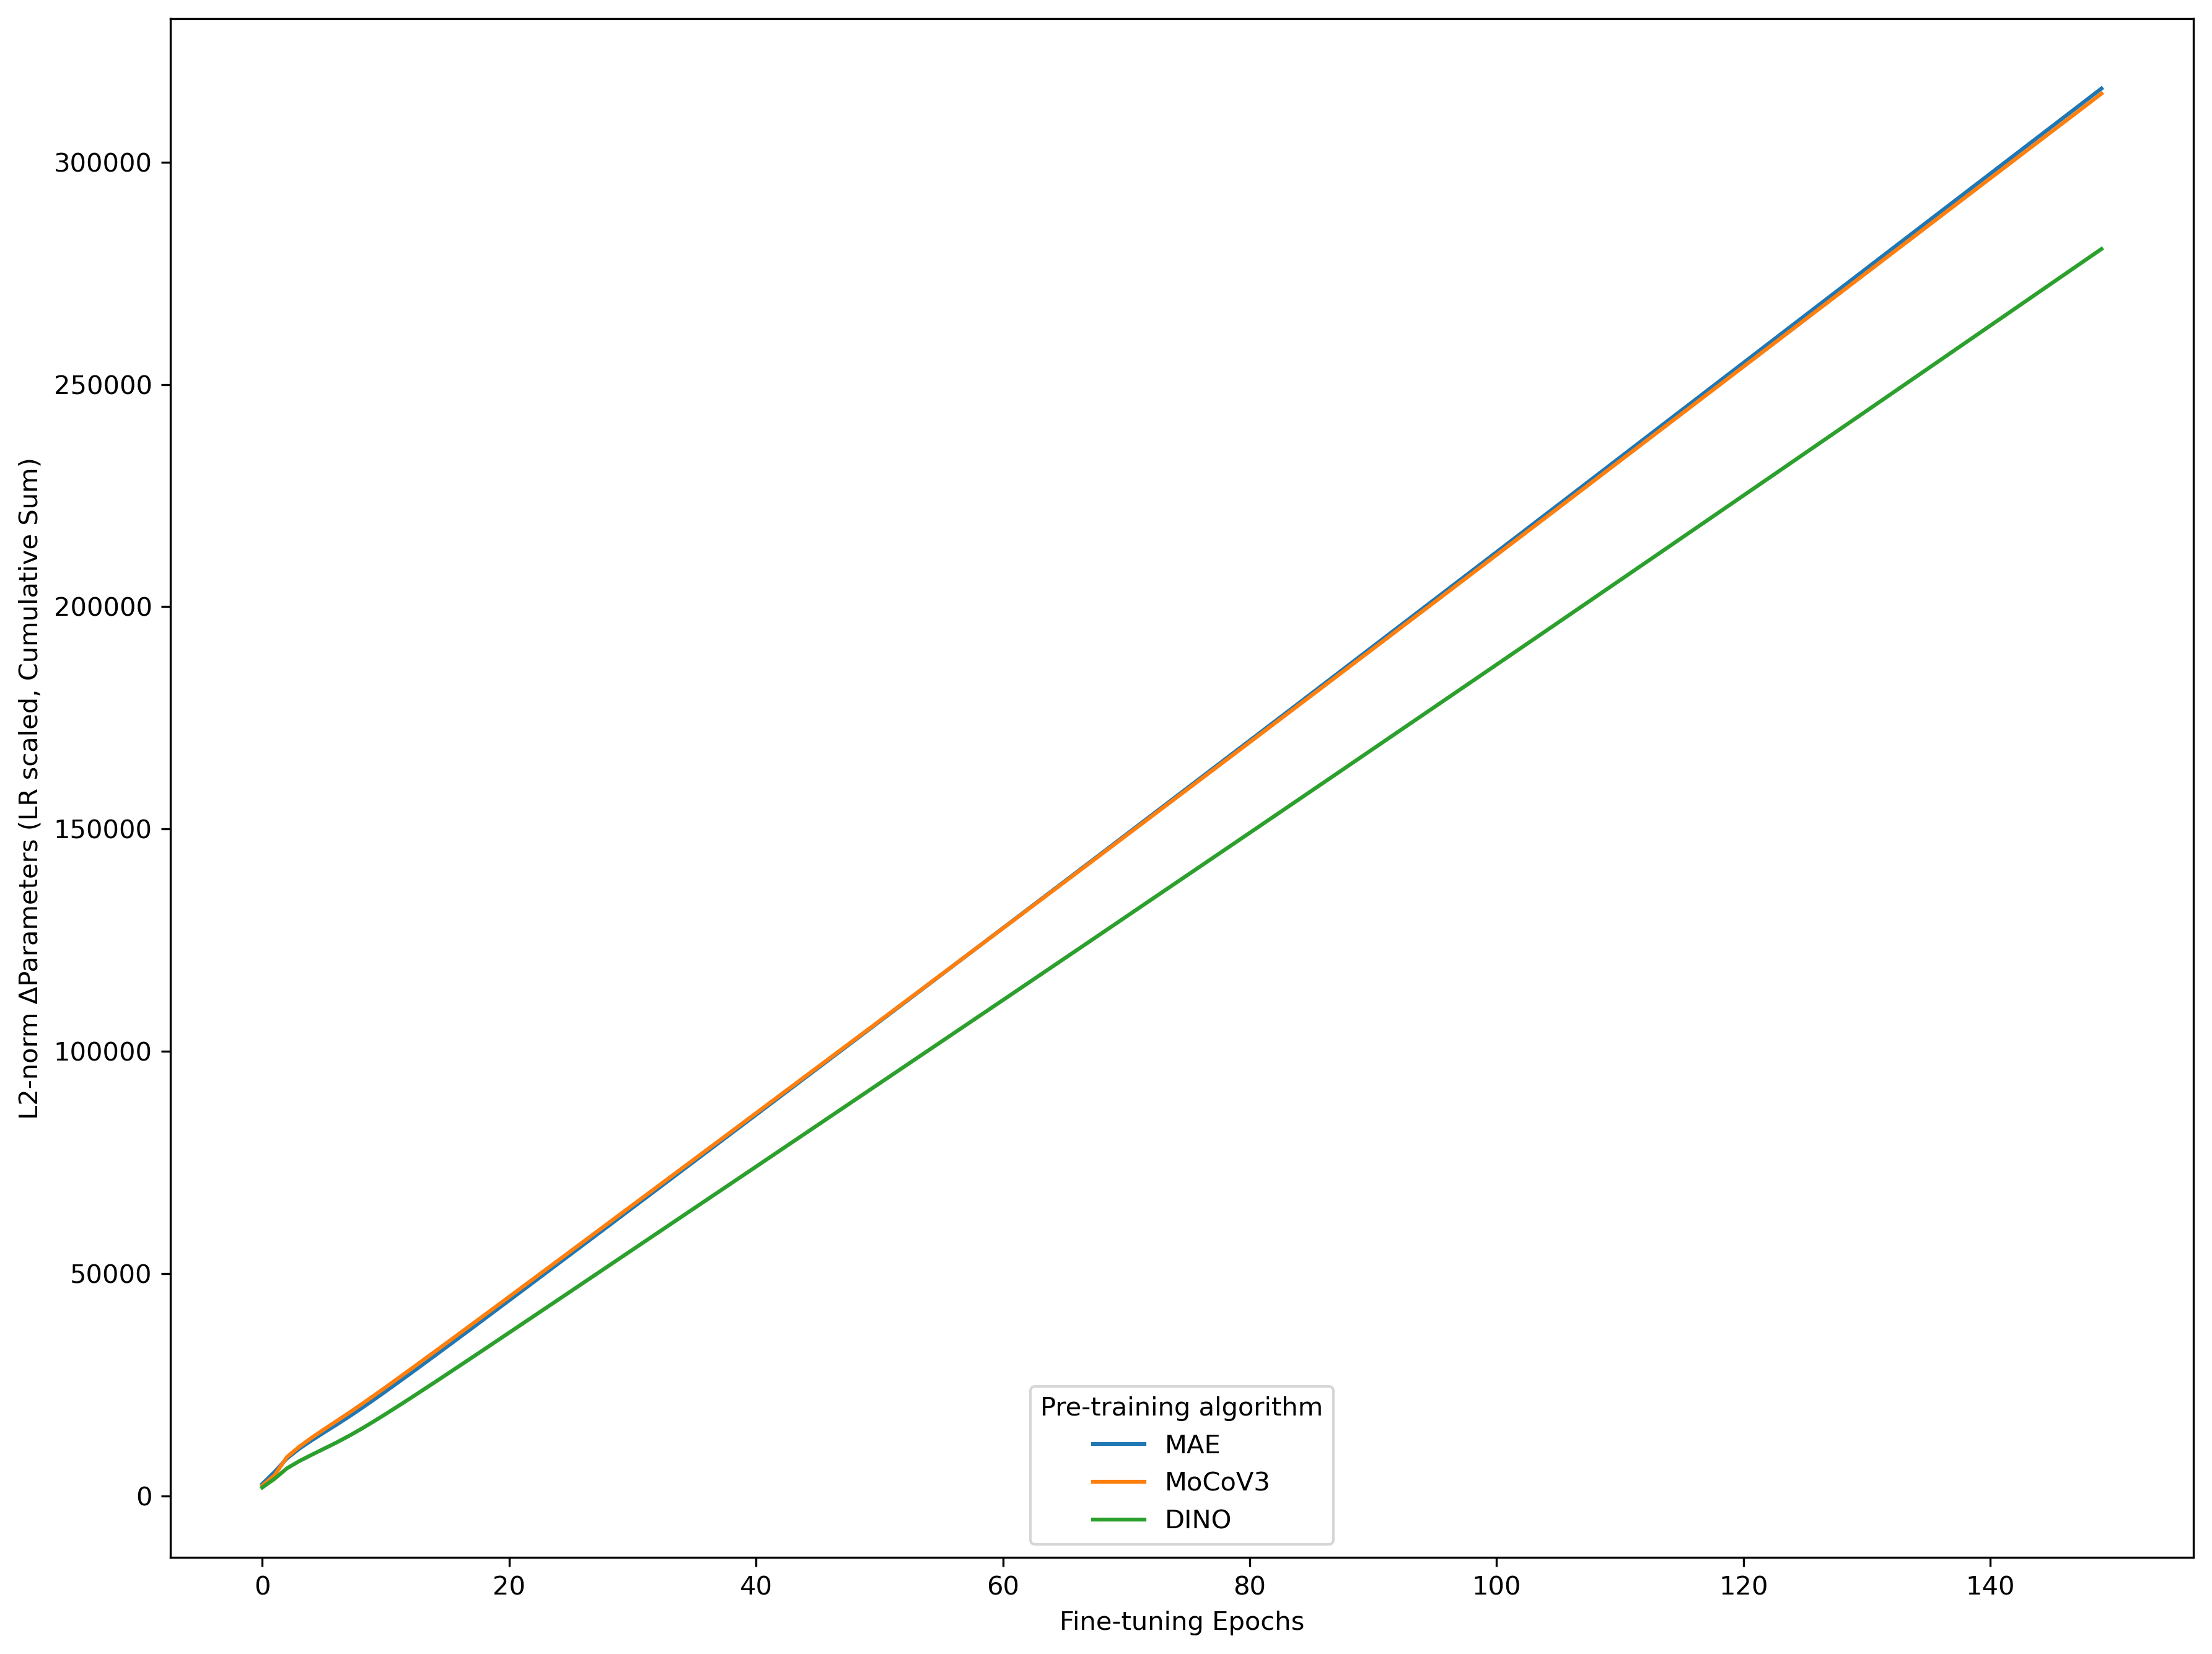

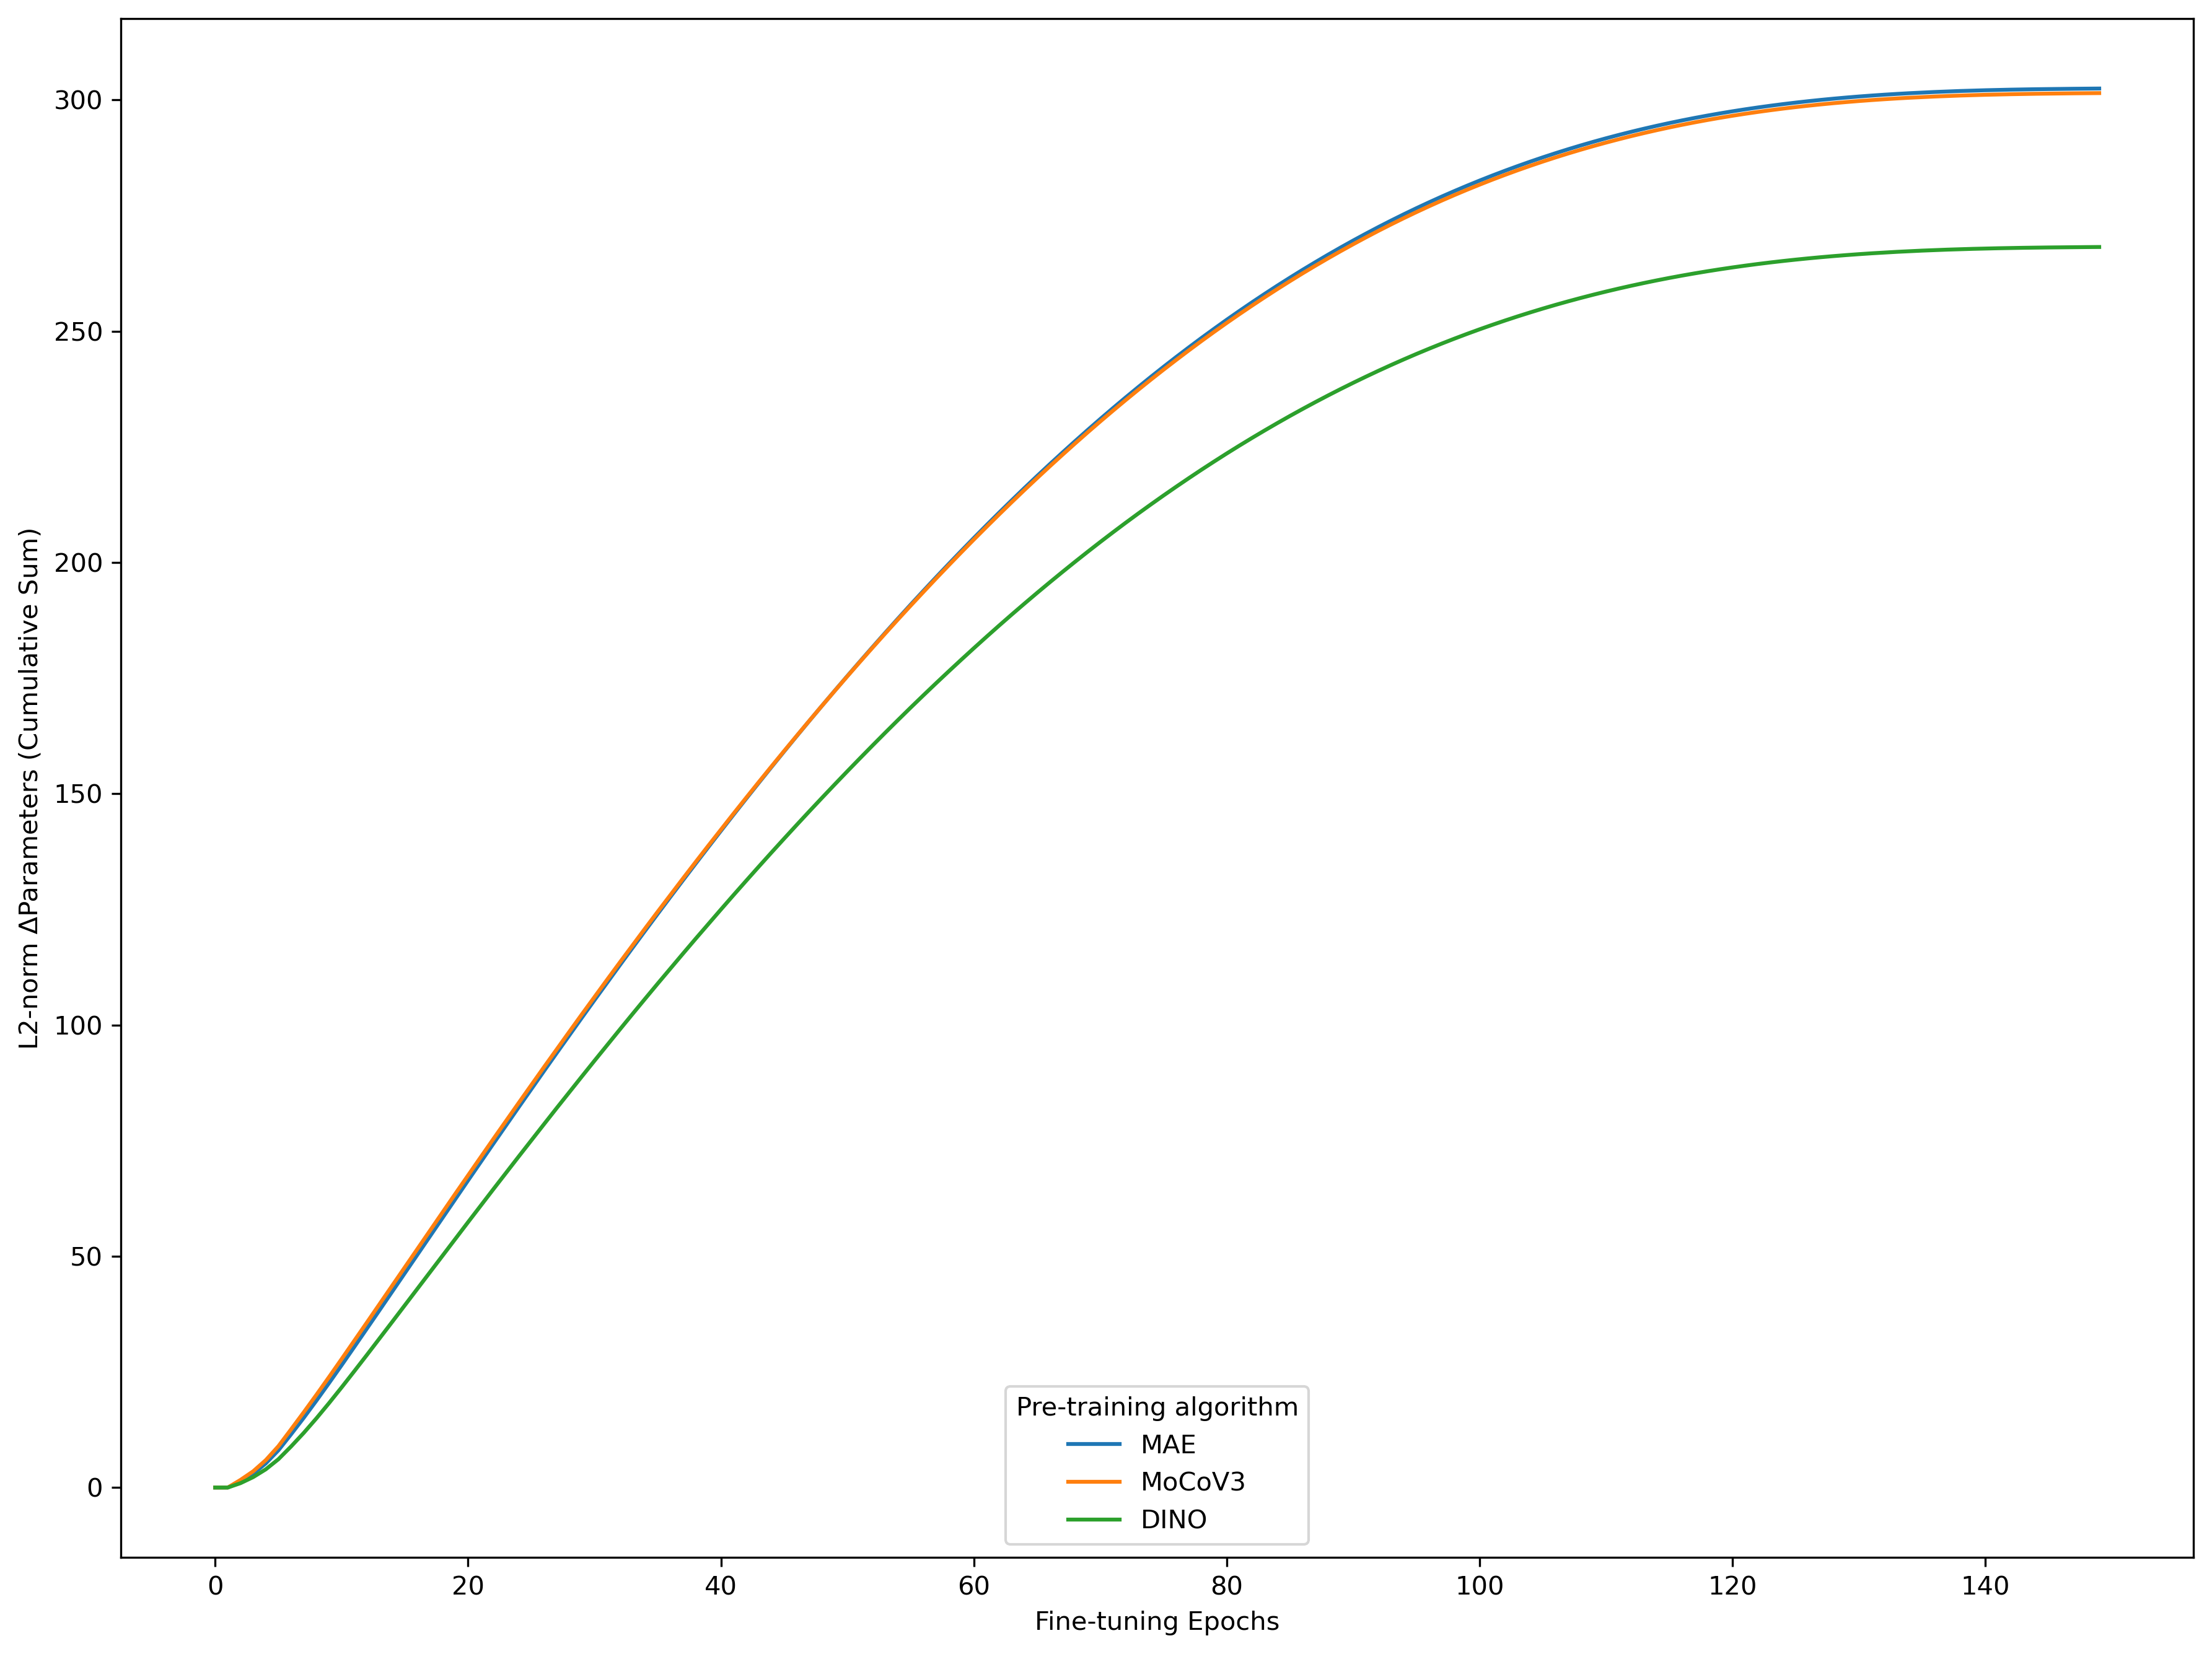

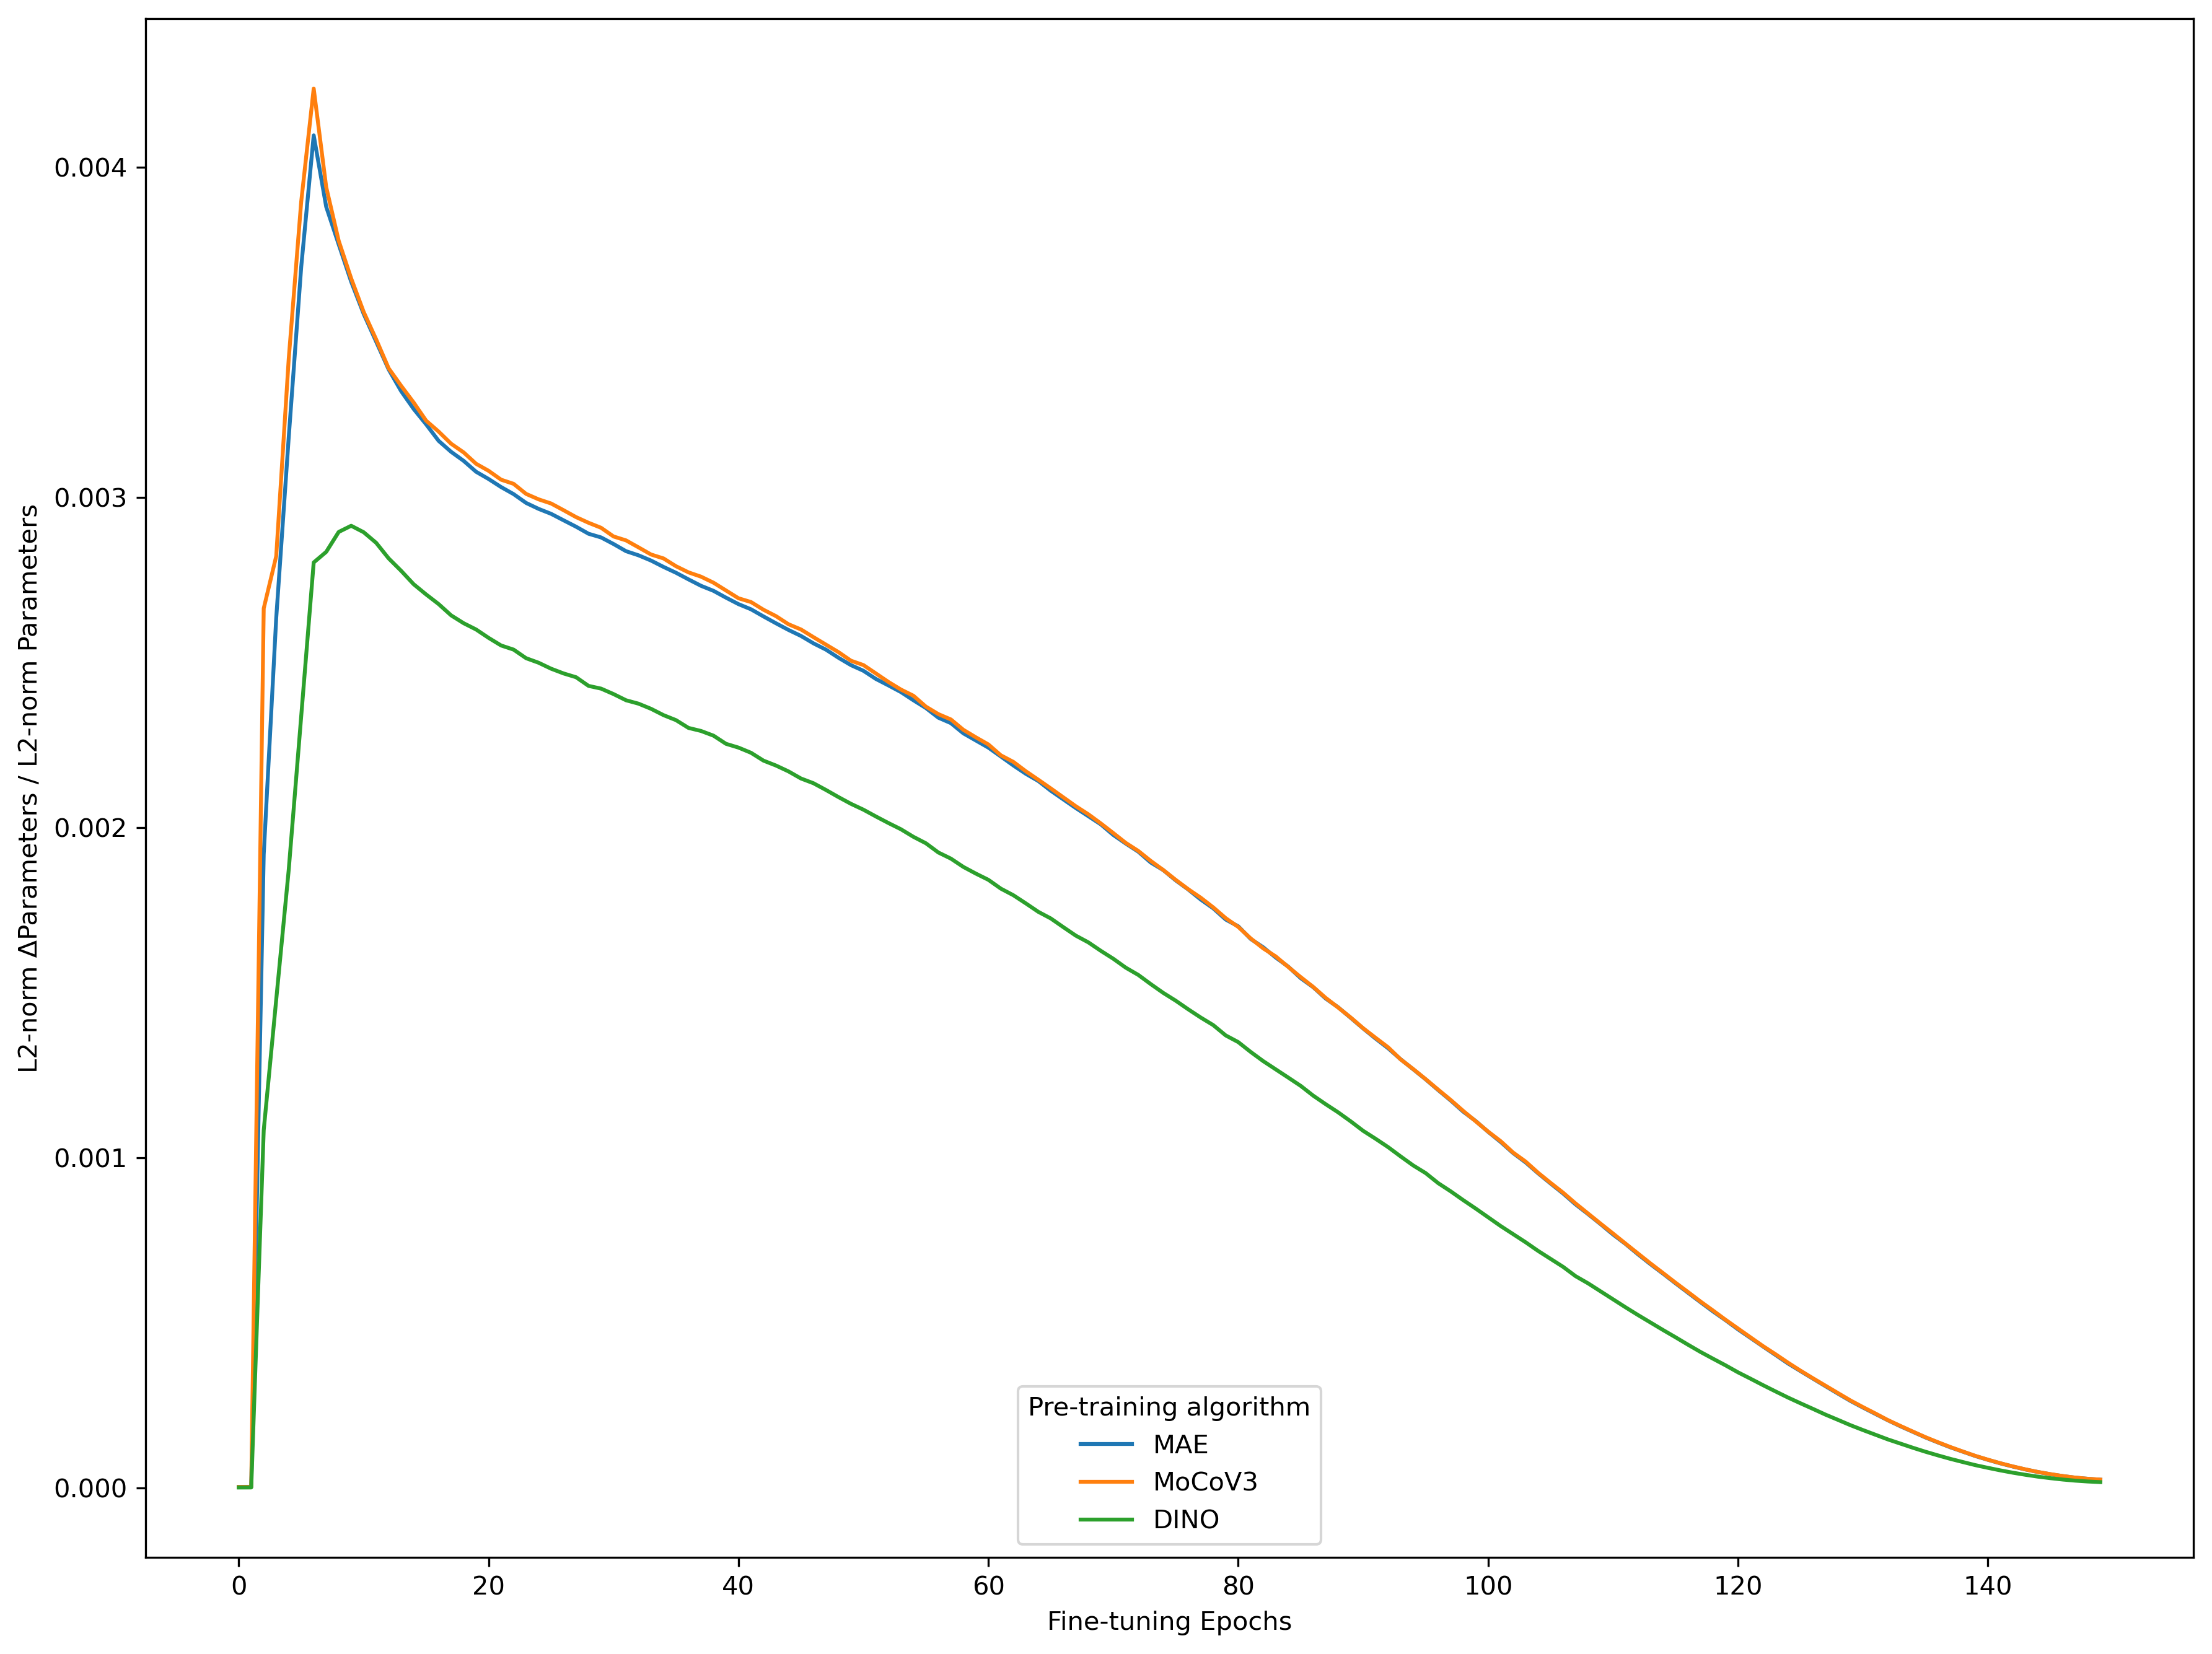

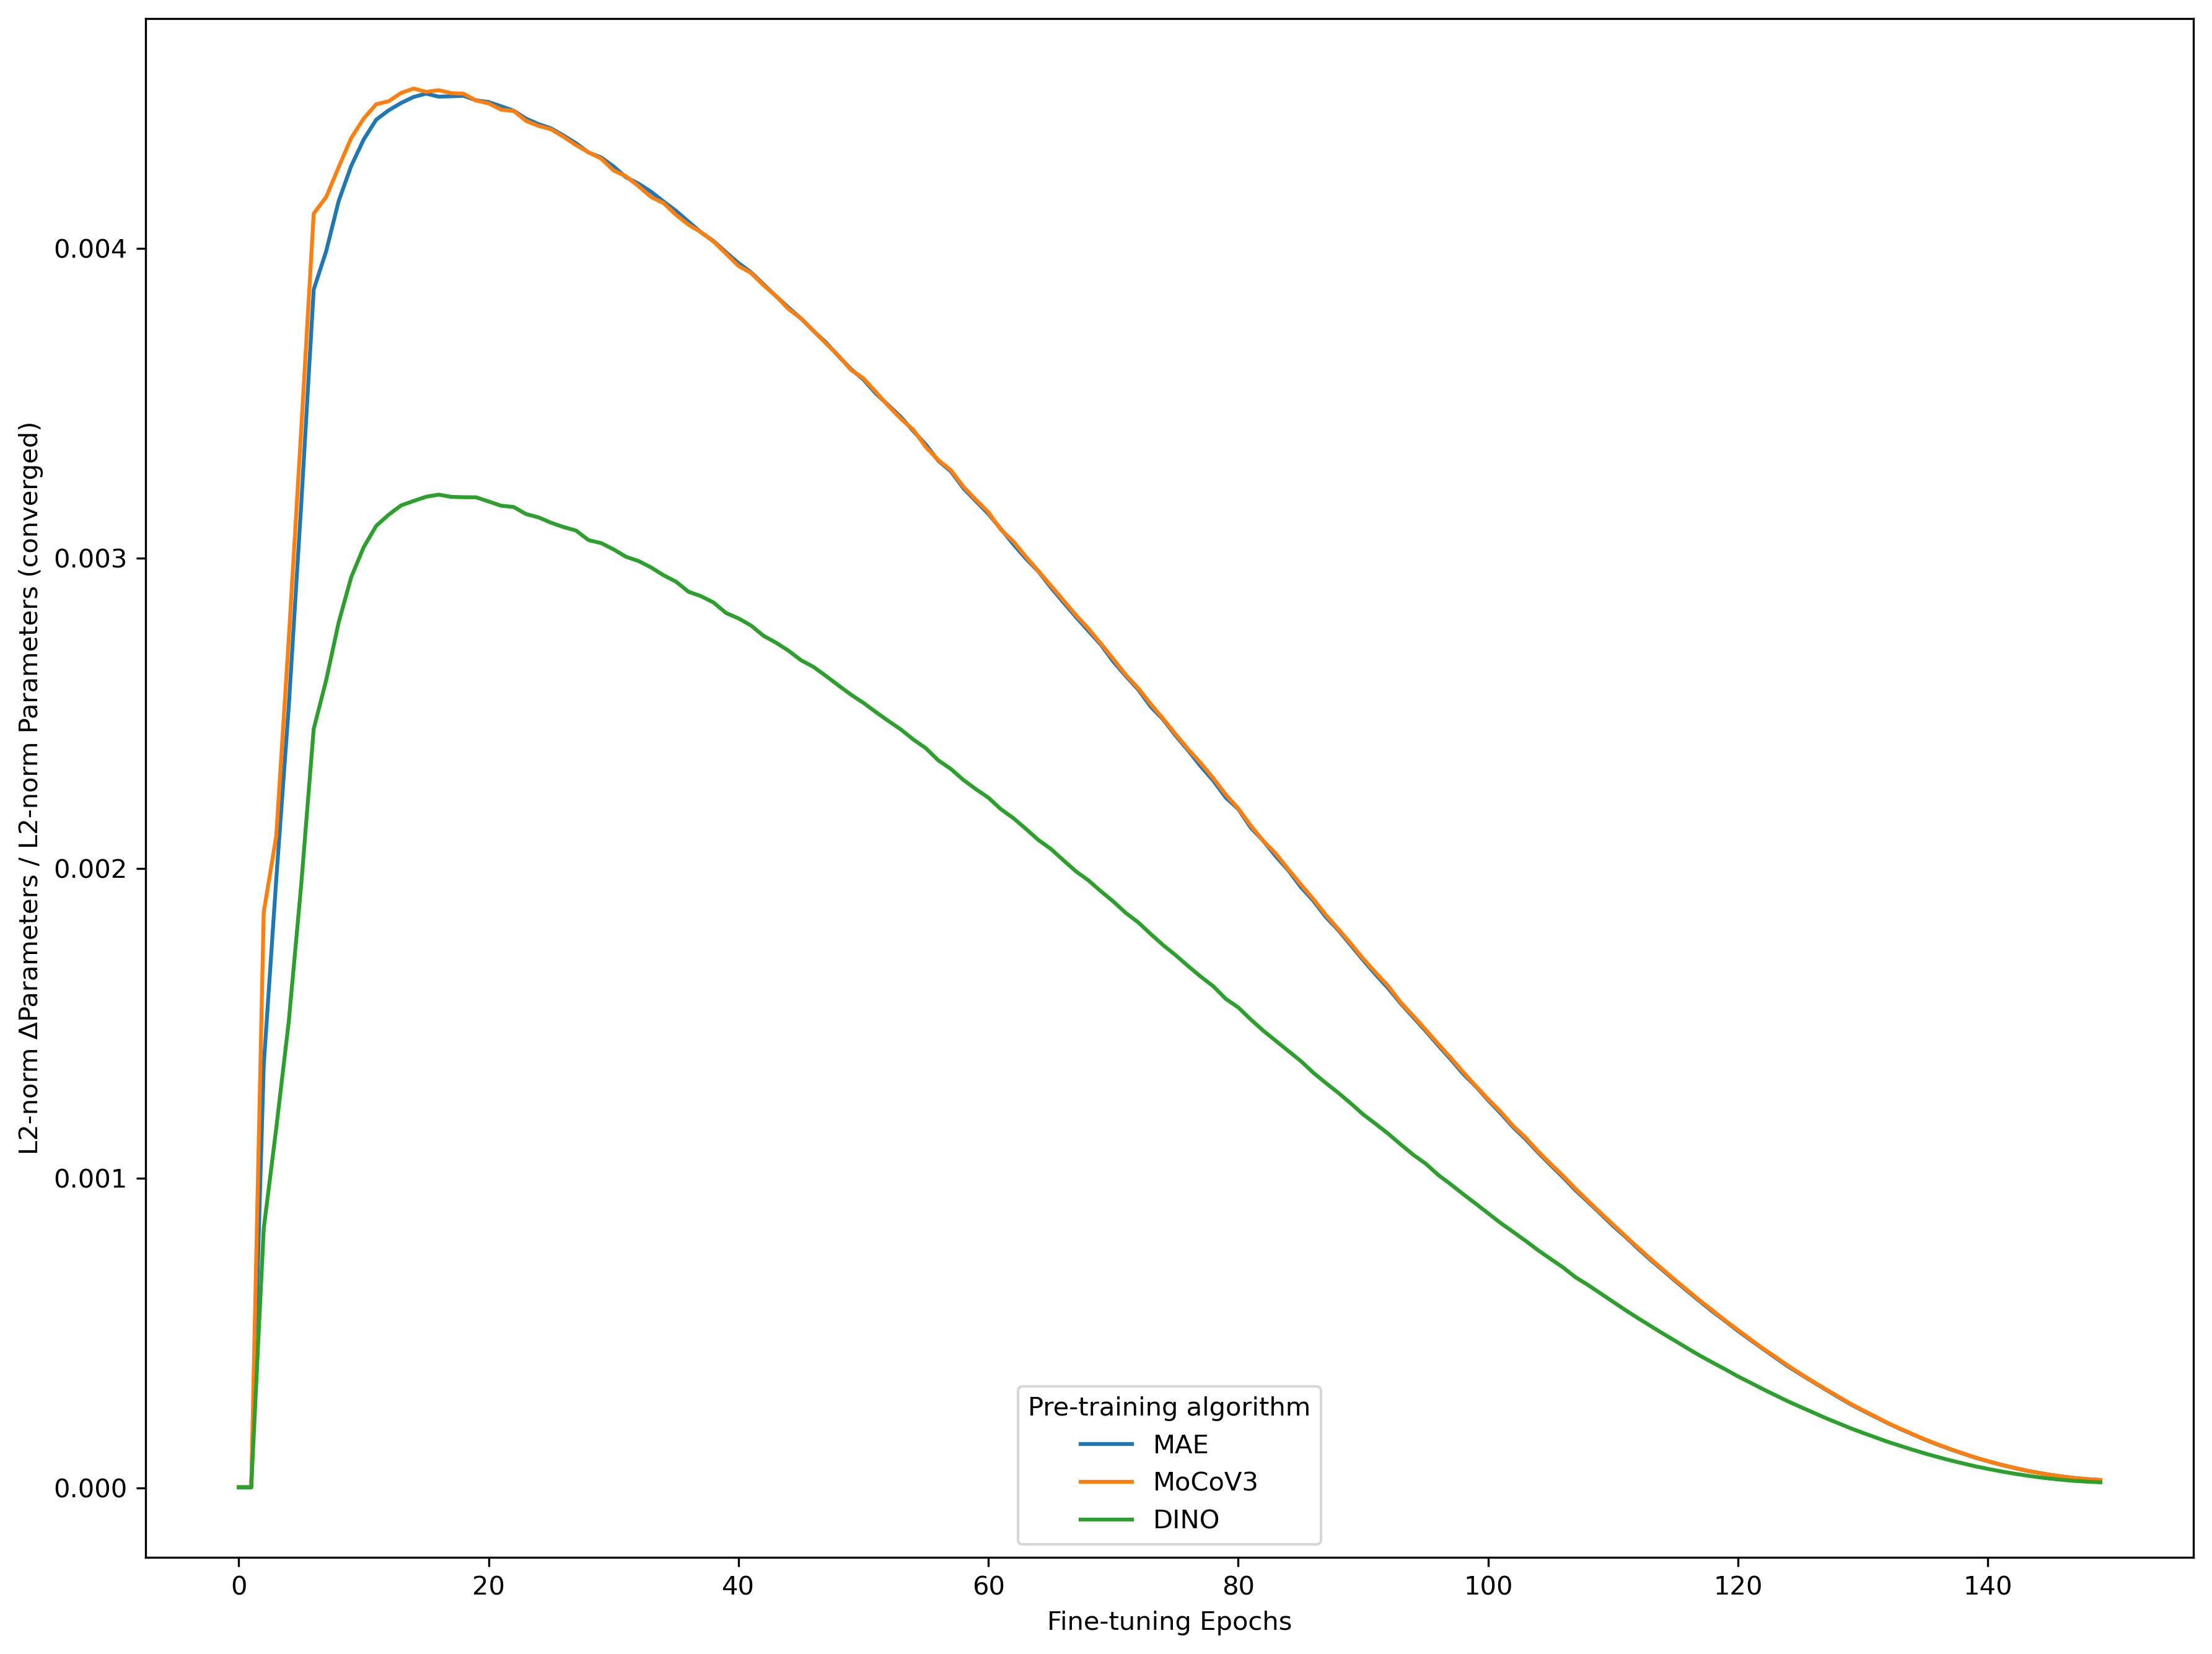

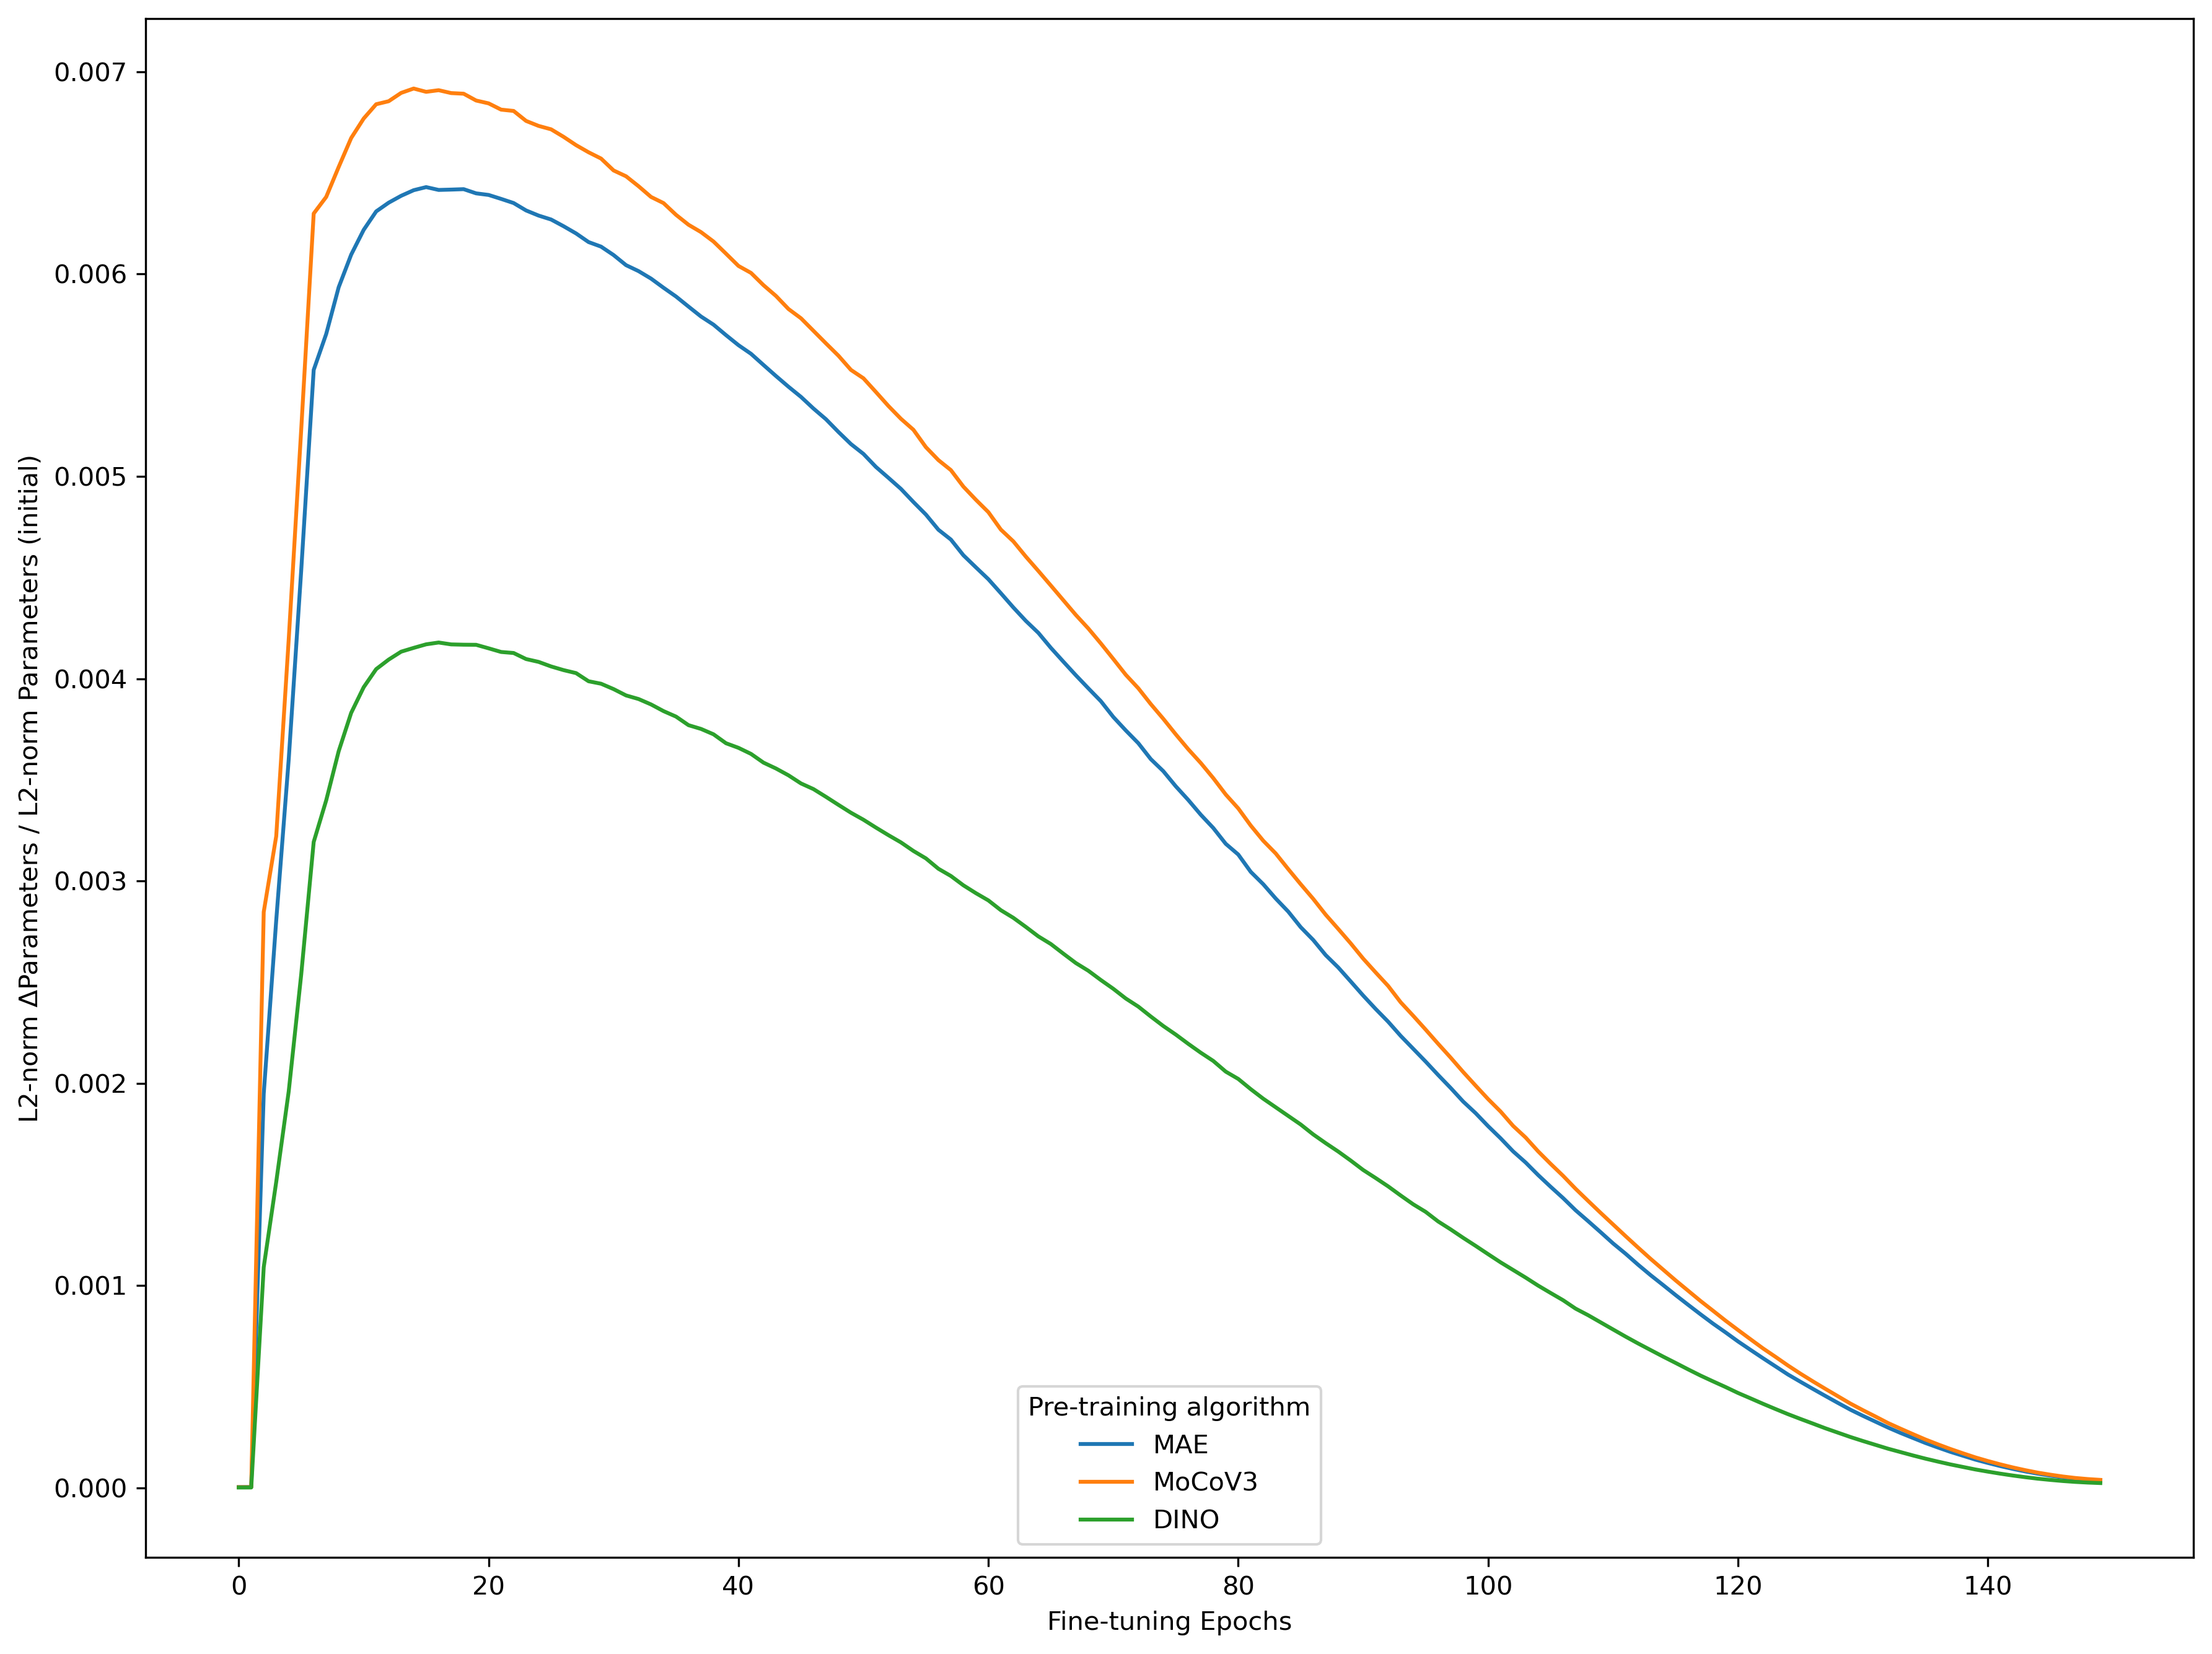

In [21]:
fig_dir = '../figures/dynamics/'

prod = itertools.combinations(results.keys(), 3)

for name1, name2, name3 in prod:

    for col in ["L2-norm ΔParameters (LR scaled)", "L2-norm ΔParameters", "L2-norm Parameters", 
                "L2-norm ΔParameters (LR scaled, Cumulative Sum)", "L2-norm ΔParameters (Cumulative Sum)",
                "L2-norm ΔParameters / L2-norm Parameters", "L2-norm ΔParameters / L2-norm Parameters (converged)",
                "L2-norm ΔParameters / L2-norm Parameters (initial)"]:
        full_fig_dir = fig_dir + col + '/'
        fig = dynamics_plot_single(full_fig_dir, results[name1], results[name2], results[name3], name1, name2, name3, col=col)